# Simplest model

The role of this model is to test the feasibility of the device.
It assumes that an external filter is used to give a correct orientation reading from the MARG (IMU + accelerometer + angular rate meter).

Assumptions:
* The robot moves in the 2D plane.
* An external system provides the yaw of the robot with respect to the world frame.
    This external system does not exhibit drift but has white gaussian noise.
    
The state of the robot is as follow:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
    x\\
    y\\
    \theta\\
    \dot{x}\\
    \dot{y}
\end{pmatrix}
\end{equation}

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sp.init_printing()

In [2]:
# defines a few variables
x, y, xdot, ydot, theta = sp.symbols('x y v_x v_y theta')
state = sp.Matrix([x, y, theta, xdot, ydot])
dt = sp.symbols('Delta_t')

## Prediction step

The prediction step uses the acceleration in body frame as control input:

\begin{equation}
\mathbf{u} = \begin{pmatrix}
    a_x\\
    a_y\\
    \omega
\end{pmatrix}
\end{equation}

Therefore, the differential equation governing the motion is given by

\begin{equation}
\mathbf{\dot{x}} = \begin{pmatrix}
\dot{x}\\
\dot{y}\\
0\\
\cos(\theta) a_x - \sin(\theta) a_y \\
\sin(\theta) a_x + \cos(\theta) a_y \\
\end{pmatrix}
\end{equation}

Using forward Euler integration we get:

\begin{equation}
\mathbf{x}_{k+1} = \mathbf{x}_{k} + \Delta_t \mathbf{\dot{x}} = \mathbf{g}\left(\mathbf{x}_{k}, \mathbf{u}_k\right)
\end{equation}


In [3]:
a_x, a_y = sp.symbols('a_x a_y') # in body frame
u = sp.Matrix([a_x, a_y])
dx = sp.Matrix([xdot,
                ydot,
                0,
                sp.cos(theta) * a_x - sp.sin(theta) * a_y,
                sp.sin(theta) * a_x + sp.cos(theta) * a_y])
g = state + dt * dx

## Correction step

For this model, we define two measurement functions:

1. The first one is just giving the angle, as output by the angular position system.
2. The second one represents the distance to a beacon at position $\mathbf{b}$.

The first measurement model is simply:

\begin{equation}
h_{\theta}(\mathbf{x}) = \theta
\end{equation}

The second measurement model is given by:

\begin{equation}
h_b(\mathbf{x}, \mathbf{b}) = \sqrt{(x - b_x)^2 + (y - b_y)^2}
\end{equation}

In [4]:
h_theta = sp.Matrix([theta])
b_x, b_y = sp.symbols('b_x b_y') # beacon position
h_b = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])

## EKF implementation

Some parts of the model are already extracted into their own module (`simple_module.py`), so take a look there for details.

To implement the EKF, we will need the jacobians of the model. We can derivate them automatically using Sympy.

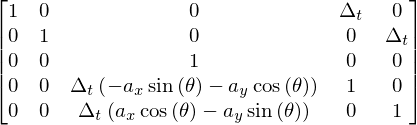

In [5]:
g.jacobian(state)

In [6]:
h_theta.jacobian(state)

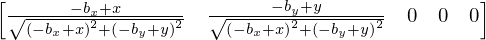

In [7]:
h_b.jacobian(state)

# Simulation

In [8]:
# Setup the simulation
from simple_model import SimpleModel
import trajectories

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]

# Update rate
dt = 1 / 200

# Value taken from the MPU9250 datasheet (8 mg RMS)
accelerometer_noise_std = 8e-3 * 9.81

# Sample covariance for the model
Q_b = np.array([[10]])
Q_theta = np.array([[0.1]])
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1])

In [9]:
angle, angle_estimated, angle_measured = [], [], []
x, xhat = [], []
y, yhat = [], []
acc = []
ts = []

estimator = SimpleModel(dt, R, Q_theta, Q_b)

for i, p in zip(range(10000), trajectories.generate_circular_traj(1, np.deg2rad(20), dt)):
    ts.append(p.timestamp)
    
    # control input
    u = np.array([p.acc[0], p.acc[1]]) + np.random.normal(0, accelerometer_noise_std, 2)
    acc.append(u)
    estimator.predict(u)
    
    # Angle measurement
    z = p.theta + np.random.normal(0, 0.1)
    estimator.correct_angle(z)
    angle_measured.append(z)
    
    # Beacon update
    if i % 20 == 0:
        for bx, by in BEACON_POS:
            distance = np.sqrt((p.pos[0]-bx)**2+(p.pos[1]-by)**2)
            z = distance + np.random.normal(0, 0.03)
            estimator.correct_beacon(bx, by, z)

    angle.append(p.theta)
    angle_estimated.append(estimator.theta)
    
    xhat.append(estimator.x)
    x.append(p.pos[0])
    
    yhat.append(estimator.y)
    y.append(p.pos[1])


## Results

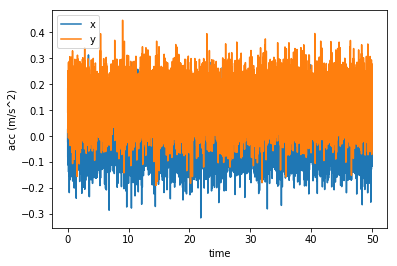

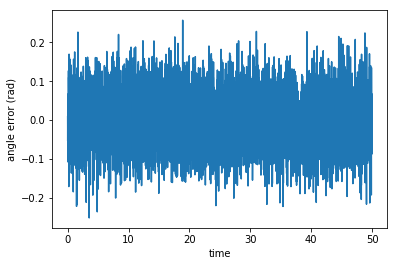

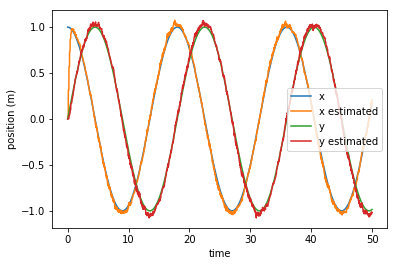

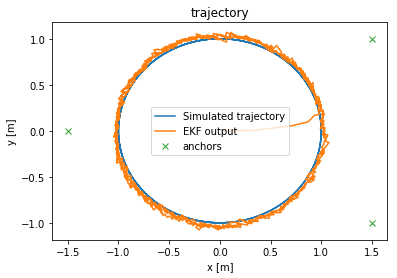

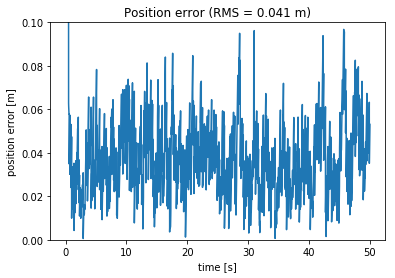

In [10]:
plt.plot(ts, [s[0] for s in acc])
plt.plot(ts, [s[1] for s in acc])
plt.xlabel('time')
plt.ylabel('acc (m/s^2)')
plt.legend(['x', 'y'])
plt.show()

plt.plot(ts, [a-b for a, b in zip(angle, angle_estimated)])
plt.xlabel('time')
plt.ylabel('angle error (rad)')
plt.show()

plt.plot(ts, x)
plt.plot(ts, xhat)
plt.plot(ts, y)
plt.plot(ts, yhat)
plt.xlabel('time')
plt.ylabel('position (m)')
plt.legend(('x', 'x estimated', 'y', 'y estimated'))
plt.show()

plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('Simulated trajectory', 'EKF output', 'anchors'))
plt.gcf().savefig('simple_model_trajectory.pdf')
plt.title('trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.show()

error = [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)]
plt.plot(ts, error)
plt.ylim(0., 0.1)
plt.xlabel('time [s]')
plt.ylabel('position error [m]')
plt.title('Position error (RMS = {:.3f} m)'.format(np.mean(error)))
plt.gcf().savefig('simple_model_error.pdf')
plt.show()